# **La Ramona - Spotify For Artists**

### Introduction

This notebook presents an Exploratory Data Analysis of Spotify streaming data collected manually from 'Spotify For Artists', which offers more comprehensive historical records than the public API.

Our dataset includes information on streams, listeners, and followers over time, as well as performance metrics for individual songs, geographic distribution of streams, and playlist appearances.

While not exhaustive, this analysis aims to visualize key performance trends over time and highlight noteworthy insights for potential deeper investigation in the future.

## **Exploratory Data Analysis**

### Imports and data loading


In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import plotly.express as px 
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from IPython.display import display_html
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter


#### Daily Total Audience Data

Firstly, we have an Audience.csv which contains total daily streams, listeners & follower count. 
We can explore this to get a good idea of overall performance over time.

In [77]:
df_audience = pd.read_csv("Data/audience.csv")
df_audience['date']= pd.to_datetime(df_audience['date'])
df_audience = df_audience.set_index('date')

#### Time Series Function
Building a function to plot our various data points over time, Time Series Vizualisations will be particularly useful to monitor performance over time.

In [148]:
def build_daily_timeseries(df, title, y_label, start_date='2023-01-01', resample_period='D'):

    df = df[df.index>start_date]
    if resample_period != 'D':
        df = df.resample(resample_period).last() 
    
    plt.figure(figsize=(12, 6))    
    for column in df.columns:
        plt.plot(df.index, df[column], label=column, linewidth=1)
    
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator())  
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  
    
    plt.xticks(rotation=45)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.title(title, fontsize=14, pad=20)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.show()

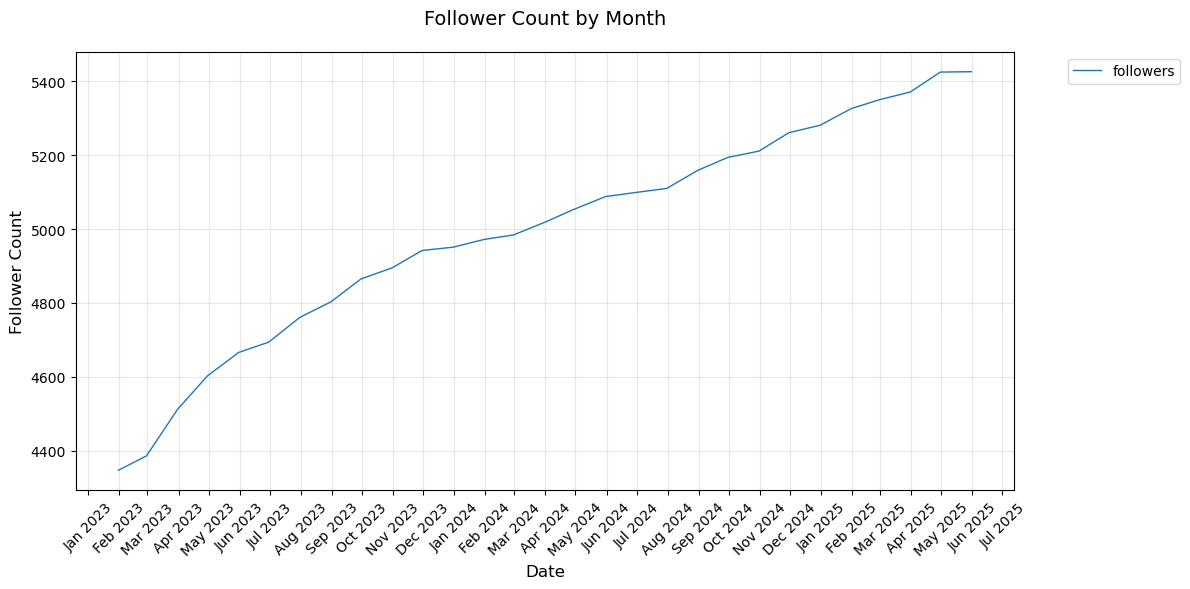

In [150]:
# For social media metrics like follower counts over time, it often makes sense to resample to a weekly cadence.
(build_daily_timeseries(df_audience[['followers']],
                        'Follower Count by Month', 
                        'Follower Count',
                        resample_period='ME'))

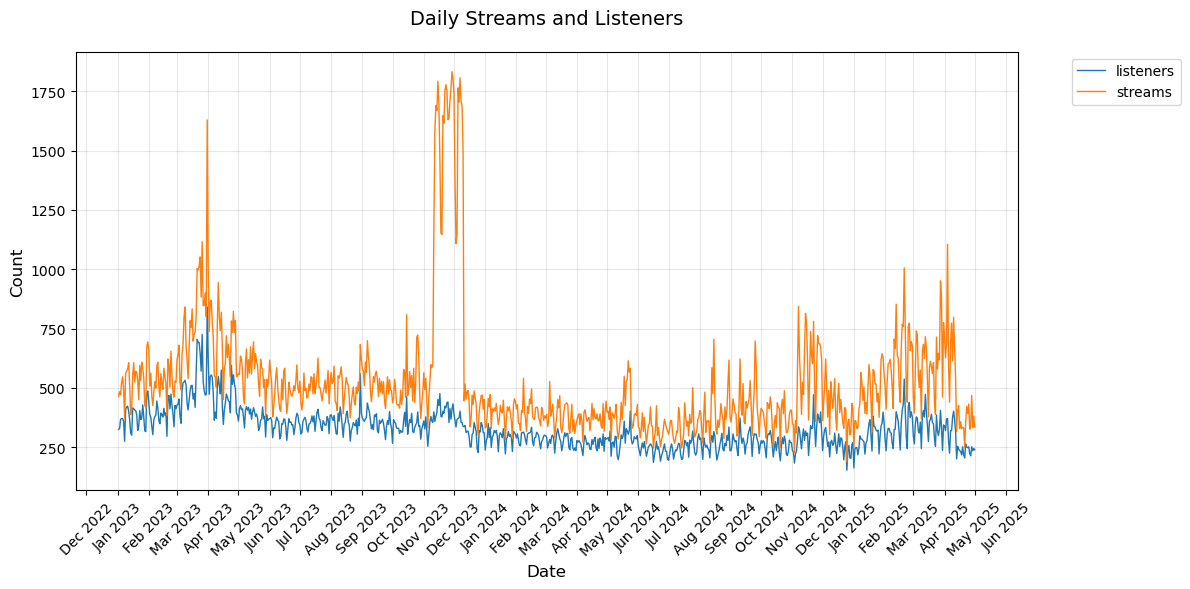

In [152]:
(build_daily_timeseries(df_audience[['listeners','streams']],
                            'Daily Streams and Listeners','Count'))

In [154]:
def display_side_by_side(*args, titles=()):
    html_str = ''
    if titles:
        for df, title in zip(args, titles):
            html_str += f"""
            <div style="display:inline-block; vertical-align:top; margin-right:30px">
                <h3 style="text-align:center">{title}</h3>
                {df.to_html()}
            </div>
            """
    else:
        for df in args:
            html_str += f"""
            <div style="display:inline-block; vertical-align:top; margin-right:30px">
                {df.to_html()}
            </div>
            """
    display_html(html_str, raw=True)

In [156]:

display_html("""
<h2>Dates with the highest total Streams</h2>
<p>The following tables display the weeks with the highest streaming totals.</p>
<p>The data is split into two separate tables to allow comparison between different time periods.</p>
<p>Key Insight, the best performing week after 2024 wouldn't be in the top 10 of before 2024</p>
""", raw=True)

older = (df_audience[df_audience.index < '2024-01-01']
         .resample('W')
          .agg({'streams': 'sum'})
          .rename(columns={'streams': 'weekly_streams'})
          .sort_values('weekly_streams', ascending=False)
          .head(10)
         )

recent = (df_audience[df_audience.index > '2024-01-01']
          .resample('W')
          .agg({'streams': 'sum'})
          .rename(columns={'streams': 'weekly_streams'})
          .sort_values('weekly_streams', ascending=False)
          .head(10)
         )

# Display side by side
display_side_by_side(older, recent, titles=['Highest Streams up to 2024', 'Highest Streams from 2024'])


Dates with the highest total Streams 
 The following tables display the weeks with the highest streaming totals. 
 The data is split into two separate tables to allow comparison between different time periods. 
 Key Insight, the best performing week after 2024 wouldn't be in the top 10 of before 2024

,weekly_streams
date,
2023-11-26,11806
2023-12-03,11325
2023-12-10,11316
2023-11-19,10604
2023-03-26,6862
2023-04-02,6748
2023-11-12,5508
2023-03-19,5193
2023-04-16,5191


#### Key Observations:
* **2023 Spikes:** Major activity peaks occurred in March and November 2023 (cause requires further investigation)
* **2024 Performance:** Relatively steady streams and listener counts throughout the year
* **November 2024:** Notable increase coinciding with new album release
* **Early 2025 Growth:** Stream spikes in February and April 2025 correlated with:
  * Performance at Colombia's largest festival
  * Increased social media visibility and sharing
* **Follower Count** Grown by over 1000 in 2.5yrs, but majority of followers gained in 2023.

### Overall Assessment
The data indicates that while overall growth is slowing down across key performance indicators, recent events have produced promising improvements. These recent positive trends provide potential building blocks for future growth strategies.

## Analysing Streams Split by Song

Using another .csv collected from 'Spotify for Artists' , we have collected Streaming data dating back to the start of 2024.

The songs selected are a mixture of Ramona's most popular songs and also the recent album.

In [160]:
df_streams = pd.read_csv("Data/top_ten_dailystreams.csv")
df_streams['date']= pd.to_datetime(df_streams['date'])
df_streams = df_streams.set_index('date')

df_streams_2025 = df_streams[df_streams.index>'2025-01-01']

In [162]:
df_streams_2025.describe()

,Biutiful,Brio,Cherokee,Lo Que Nadie Pudo,Nunca Me Olvides,Quien Contra El Amor,Quier Sentirlo Otra Vez,Se Acabo el Amor,Senorita Ley D,Te Tengo y No Te Tengo,Temporal
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,22.375000,88.775000,46.658333,9.000000,36.725000,48.150000,27.808333,52.116667,87.483333,39.375000,11.266667
std,4.979053,16.063144,9.251387,3.559813,26.584877,31.486865,16.441031,22.994769,52.714386,8.176686,10.650864
min,11.000000,59.000000,29.000000,3.000000,3.000000,5.000000,5.000000,18.000000,6.000000,15.000000,1.000000
25%,19.750000,76.750000,40.000000,7.000000,13.750000,19.000000,16.000000,35.750000,50.750000,34.000000,5.000000
50%,22.000000,85.000000,47.000000,8.000000,27.500000,43.000000,24.000000,49.500000,83.000000,39.000000,9.000000
75%,26.000000,97.250000,53.000000,11.000000,57.000000,71.500000,36.250000,65.250000,119.500000,44.250000,14.000000
max,36.000000,142.000000,73.000000,25.000000,126.000000,138.000000,109.000000,126.000000,287.000000,58.000000,88.000000


### Visualise Streams by Song over Time

It makes sense to look back over different windows as some of the releases came out around 7 months ago, therefore don't fit the full period visualisations from the beginning of the dataset `2024-01-01` .

#### Full Period

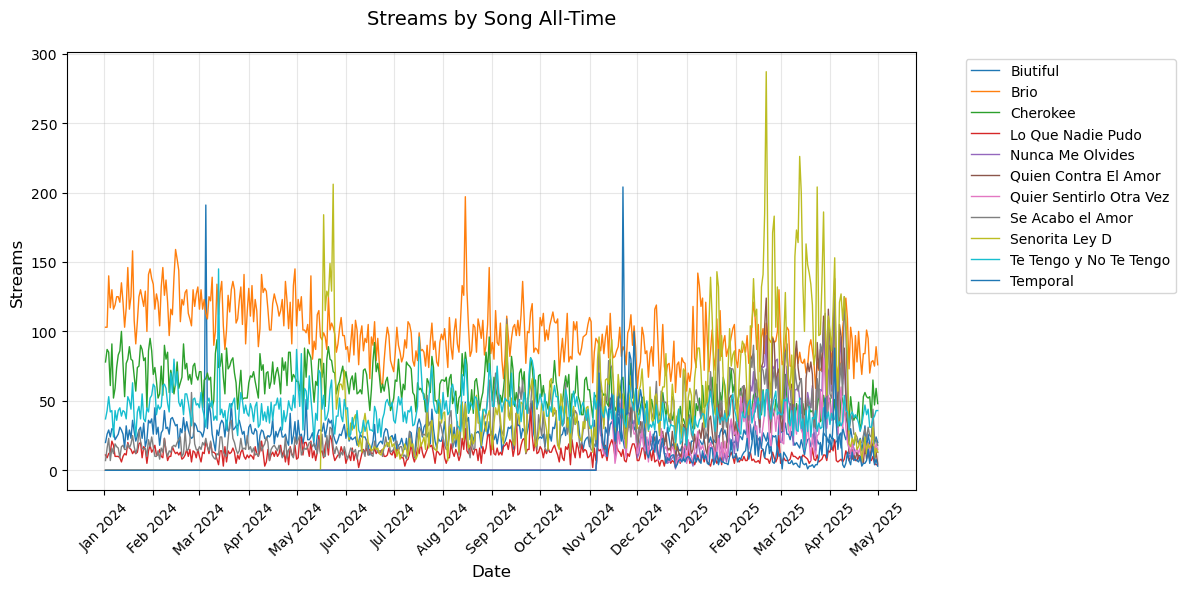

In [165]:
build_daily_timeseries(df_streams, 'Streams by Song All-Time', 'Streams', '2024-01-01')

#### From start of 2025

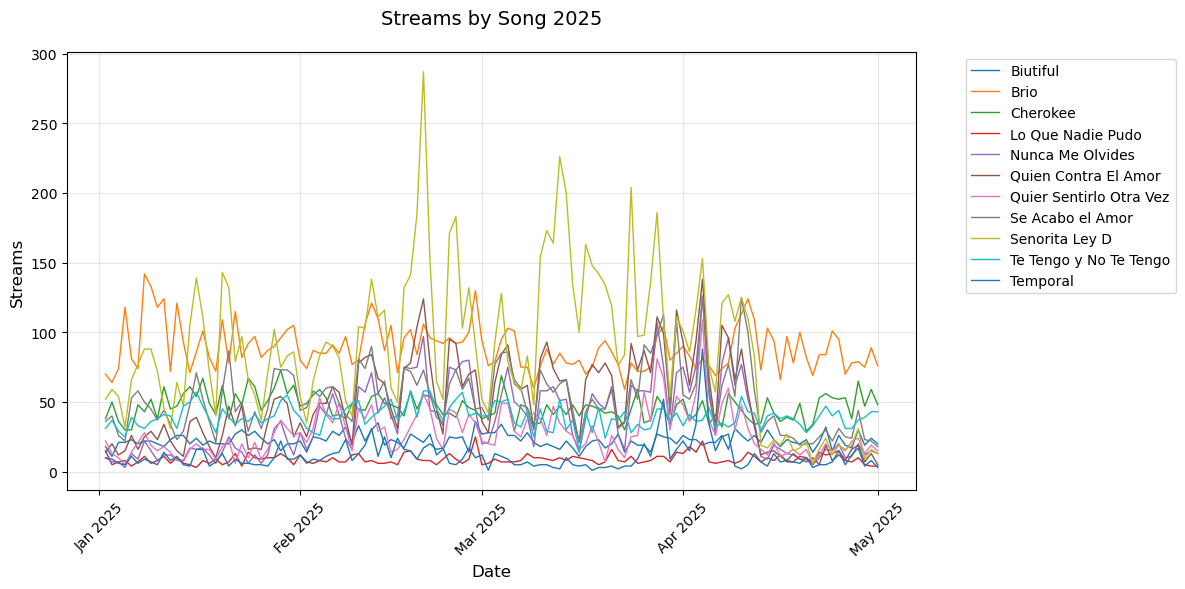

In [315]:
build_daily_timeseries(df_streams, 'Streams by Song 2025' ,'Streams', '2025-01-01')

#### Insights

It would appear there were spikes in Feb and May of 2024 and March and April of 2025.

`Señorita Ley D` is the best performing song, whilst some of the older songs like `Temporal` and `No Te Tengo` perform consistently well across the year.

When looking into the highest Streams by Date, it also mirrors the visualisation, with mid February & late March/ early April being days with the highest streams.

## Geographic Analysis

#### Listeners by City and Country

Using another .csv collected from 'Spotify for Artists' , we have collected Streaming data by city which looks back 28 days.

Initially we just have the Country and City, we will add `lat` and `lon` co-ordinates to the .csv and resave it.

In [40]:
df_geog = pd.read_csv("Data/listenersbycity.csv")
df_geog['count'] = df_geog['count'].str.replace(',', '').astype(int)
df_geog.head(5)

,country,city,count
0,Colombia,Bogotá,1456
1,Colombia,Medellín,328
2,Mexico,Mexico City,173
3,Colombia,Santiago de Cali,99
4,Ecuador,Quito,78


In [178]:
by_country = (df_geog[["country", "count"]].groupby("country")
 .agg(
    Listener_Count_by_Country=('count', 'sum'))
 .sort_values(by='Listener_Count_by_Country', ascending=False)
 
)
by_city = (df_geog[["country", "city", "count"]].groupby(["country", "city"])
 .agg(
    Listener_Count_by_City=('count', 'sum'))
 .sort_values(by='Listener_Count_by_City', ascending=False)
.head(15) 
)
display_side_by_side(by_country, by_city, titles=['Listeners by Country', 'Listeners by City'])


,Listener_Count_by_Country
country,
Colombia,2075
Mexico,815
Ecuador,94
Spain,73
Chile,65
United States,51
Argentina,42
Costa Rica,39
Peru,39


In [6]:
# Initialize geolocator with a user agent
geolocator = Nominatim(user_agent="city_geo_locator")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# Create a new column with combined city + country for better accuracy
df_geog['location'] = df_geog['city'] + ', ' + df_geog['country']

unique_locations = df_geog['location'].unique()
location_coords = {}

for loc in unique_locations:
    try:
        geo = geocode(loc)
        if geo:
            location_coords[loc] = (geo.latitude, geo.longitude)
        else:
            location_coords[loc] = (None, None)
    except Exception as e:
        location_coords[loc] = (None, None)

# Map lat/lon back to the DataFrame
df_geog['lat'] = df_geog['location'].map(lambda x: location_coords.get(x, (None, None))[0])
df_geog['lon'] = df_geog['location'].map(lambda x: location_coords.get(x, (None, None))[1])

# Clean 'count' column: remove commas and convert to int
df_geog['count'] = df_geog['count'].str.replace(',', '').astype(int)

In [180]:
#save to a new file
#df_geog.to_csv('Data/listenersbycity_coord.csv', index=False)  

In [20]:
df_geog_coord = pd.read_csv("Data/listenersbycity_coord.csv")

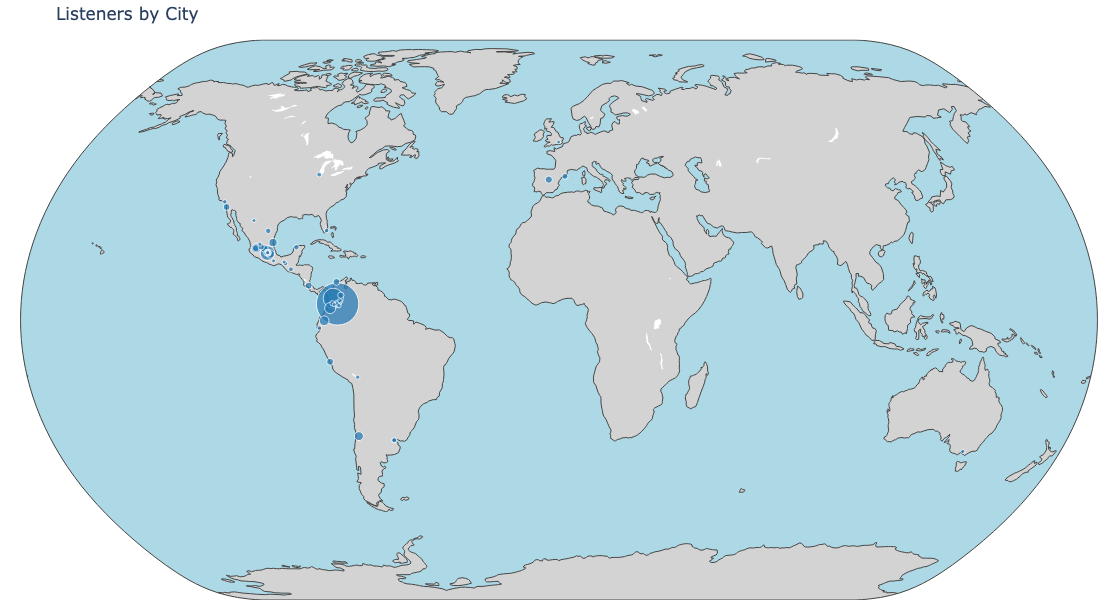

In [36]:
# Create the map
fig = px.scatter_geo(df_geog_coord,
                     lat='lat',
                     lon='lon',
                     size='count',
                     hover_name='city',
                     hover_data={'country': True, 'count': True, 'lat': False, 'lon': False},
                     projection='natural earth',
                     title='Listeners by City',
                     size_max=30,
                     color_discrete_sequence=['#1f77b4'])


fig.update_geos(
    scope="world" ,
    showland=True,
    landcolor="lightgray",
    showocean=True,
    oceancolor="lightblue"
)

fig.update_layout(
    margin=dict(l=0, r=0, t=40, b=0),
    height=600
)

fig.show()

#### Spotify Geographic Insights

* **Top City & Country:** Ramona is based in Bogota, Colombia.
* **Potential Tours:** Festivals and Venues in Mexico, Ecuador, Chile could be explored as there is a following there.
* **Social Media:** Next step would be to see if Social Media followers, are spread simmialrly.

## Spotify Playlist Analysis

#### Spotify Playlists vs User Created Playlists

Using another .csv collected from 'Spotify for Artists' , we have collected Playlist data.

In [237]:
df_playlists = pd.read_csv("Data/playlists.csv")
df_playlists['date']= pd.to_datetime(df_playlists['date_added'])
df_playlists = df_playlists.drop(columns=['date_added'])
df_playlists.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   title      98 non-null     object        
 1   author     98 non-null     object        
 2   listeners  98 non-null     int64         
 3   streams    98 non-null     int64         
 4   date       80 non-null     datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 4.0+ KB


In [245]:
df_playlists[df_playlists['author']=='-']

df_playlists = df_playlists.replace(to_replace=r'-', value='User', regex=True)

In [320]:
playlist_ratio = (
    df_playlists
    .groupby("author")
     .agg(Total_Count=('streams', 'count'))
     .sort_values(by='Total_Count', ascending=False)
)
playlist_streams =  (
    df_playlists
    .groupby("author")
    .agg(Total_Sum=('streams', 'sum'))
     .sort_values(by='Total_Sum', ascending=False)
)
playlist_listeners =  (
    df_playlists
    .groupby("author")
    .agg(Total_Sum=('listeners', 'sum'))
     .sort_values(by='Total_Sum', ascending=False)
)
display_side_by_side(playlist_ratio, playlist_streams,playlist_listeners , titles=['Spotify vs User Playlist Count', 
                                                                                 'Spotify vs User Created Total Streams',
                                                                                 'Spotify vs User Created Total Listeners'
                                                                                                   ])

,Total_Count
author,
User,79
Spotify,19
,Total_Sum
author,
Spotify,53057
User,4397
,Total_Sum
author,
Spotify,16446


In [306]:
(
    df_playlists[['title', 'author', 'streams' ]]
    .groupby(["title", "author"])
    .agg(Total_Sum=('streams', 'sum'))
     .sort_values(by='Total_Sum', ascending=False)
    .head(10)
)

,,Total_Sum
title,author,
Radio,Spotify,35729
Mixes,Spotify,6359
Rock Colombia,Spotify,6311
Your DJ,Spotify,1540
Release Radar,Spotify,1343
"Rock colombiano 80’s, 90's...",User,794
Festival Utopía 2024🍃,User,634
Smart Shuffle,Spotify,498
Te tengo y no Te tengo ❤️🔥,User,424


#### Insights

Despite being present in much more 'User Generated' Playlists, the Spotify hosted Playlists have the greatest impact on Streams & Listeners.

Targeting Spotify Playlists, figuring out how to make it onto them seems like the best strategy in order to grow Streams.

Spotify Playlists generally prioritise newer music, therefore releasing new music will improve chances of reaching these valuable Spotify Playlists.  

Another plan is to create public Spotify Playlists of Songs you like mixed in with your own:
* 'Songs that have inspired me'
* 'What I listen to'
* 'Relax / Party '

### Conclusion




#### Ideas

- The top 10 highest days of streams.
- similar artists to her in cities where she is popular.
- look at the geographic following of instagram & spotify - correlated? 
- see if theres a link between instagram posts and spotify
- analyse the SEO of spotify
- find the  Audio Analysis of the top tracks, find similar songs from other artists.
- find playlists which contain songs with a similar structure and musical content, including rhythm, pitch, and timbre.
- understand the audience tastes, what else do they listen to.
- Once we have identified the genres Ramonas song best fit into, then find out the characteristics of the popular songs in that Genre.
- conduct Principal component analysis (PCA) on all the features of each of the songs (Acousticness, danceability, energy, duration, instrumentals, valence, popularity, tempo, and speechines) and find the features of the songs that group well together. - Use these to find good collaborations. ref (https://github.com/datares/TeamPink )


### Stats:

#### Regression Model: Quantifying Impact Factors
A multiple linear regression (or logistic regression for binary outcomes) can help you determine which factors most influence stream growth.

Example Model:


 | Factor Type          | Example Metrics                          | Data Source                     |
|----------------------|------------------------------------------|---------------------------------|
| **Song Characteristics** | Danceability, Energy, Valence, Duration | Spotify API (`audio_features`)  |
| **Social Media**     | TikTok shares, Instagram Reels views     | Instagram/TikTok APIs or manual |
| **Promotion**        | Playlist adds, PR campaigns              | Spotify for Artists CSV         |
| **Temporal**         | Release day, seasonality                 | Custom date features            |

#### Time-Series Analysis
Model how streams evolve post-release using:

ARIMA or Prophet to forecast trends.
Event studies: Measure impact of promotions (e.g., spikes after TikTok posts).

#### A/B Testing
**Hypothesis:** "Shorter songs (<2.5 mins) gain more streams."
**Method:** Compare streams of shortened vs. original tracks.

#### Sentiment Analysis (Social Media)
Use NLP on fan comments (Instagram/TikTok) to:
Gauge song reception (positive/negative).
Correlate sentiment with stream retention.

#### Clustering for Audience Segmentation
Group listeners by behavior (e.g., demographics, streaming patterns) using:
k-Means or DBSCAN on:
    Streaming frequency
    Geographic location
    Playlist interactions
**Actionable Insight:**
Target high-value clusters with tailored ads.


How to increase streams

- creating great playlists with own songs in and other favourite songs
- https://www.youtube.com/watch?v=Cyvtw_zpq8A&t=1s

### Connecting with the Spotify API (spotipy)

In [38]:
import yaml
import spotipy
from spotipy.oauth2 import SpotifyOAuth

In [40]:
# Load YAML credentials safely
with open("../Keys/spotify_credentials.yaml", 'r') as file:
    creds = yaml.safe_load(file)  # Prefer safe_load over load

In [42]:
# Login with Spotify Credentials
try:
    # Authenticate
    sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
        client_id=creds['client_id'],
        client_secret=creds['client_secret'],
        redirect_uri=creds['redirect_uri'],
        scope="user-read-private user-read-email user-library-read user-top-read"
    ))
    print(f"Logged in with new credentials.")
    
except SpotifyException as e:
    print(f"Spotify API error: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")



Logged in with new credentials.


### Get List of Top Tracks

In [77]:
artist_top_tracks = sp.artist_top_tracks(creds['artist_id'])
# select the top 10 track names
i = 1
if artist_top_tracks != None:
    for track in artist_top_tracks['tracks']:
        print(f"{i}: {track["id"], track['name']}")
        i += 1



1: ('5BoA6gJzAUfa57JQ0WBt4t', 'Brío')
2: ('5YWDjRVcDMpiq2c5aTupFA', 'Señorita Ley D')
3: ('3qY0oKFlzTYfPoXS9cnn8z', 'Cherokee')
4: ('45U5BZPnQtWD0z2GWp04lc', 'Se Acabó el Amor')
5: ('07l2bAjmNxSmuDdH3ghDaX', 'Quién Contra el Amor')
6: ('5XJja9JOi51ypN62WtY6R0', 'Te Tengo y No Te Tengo')
7: ('5QCXu423YBBI2YiasmUvnb', 'Nunca Me Olvides')
8: ('7u7ROQeVY9pDVQuM5P76rO', 'Quiero Sentirlo Otra Vez')
9: ('4MkYxxx9s3QxRXASc9ZXen', 'Biutiful')
10: ('2M4UKnFXll9PYo5a2Zr6b9', 'Quemarlo Todo')
